In [240]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString

In [323]:
# Read in data
profiles_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/Avoca/photogrammetry_Xsections_Avoca.csv', skiprows=5, parse_dates=True)
profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

# Add ID column
profiles_df['site'] = profiles_df['Beach'].map(str) + '_' + profiles_df['Block'].map(str) + '_' + profiles_df['Profile'].map(str)
profiles_df.drop(['Beach', 'Block', 'Profile'], axis=1, inplace=True)

# Rename columns
profiles_df.rename({'Year/Date': 'date', 'Survey Type': 'source'}, axis=1, inplace=True)

# Compute origin and end points for each profile
origin_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmin(), ['site', 'Easting', 'Northing']]
end_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmax(), ['site', 'Easting', 'Northing']]
origin_xy.rename({'Easting': 'origin_x', 'Northing': 'origin_y'}, inplace=True, axis=1)
end_xy.rename({'Easting': 'end_x', 'Northing': 'end_y'}, inplace=True, axis=1)
end_xy.reset_index(drop=True, inplace=True)
origin_xy.reset_index(drop=True, inplace=True)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=origin_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

# Find location and distance to water / X AHD
profiles_interp = []

for i in [0.0, 0.5, 1.0]:

    out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp1d(x.Elevation, x.Chainage)(i),
                                                                           f'ahd{i}_x': interp1d(x.Elevation, x.Easting)(i),
                                                                           f'ahd{i}_y': interp1d(x.Elevation, x.Northing)(i)})
                                                      
                                                      if (x.Elevation.min() < i) & (x.Elevation.max() > i) 
                                                      
                                                      else pd.Series({f'ahd{i}_dist': np.nan,
                                                                      f'ahd{i}_x': np.nan,
                                                                      f'ahd{i}_y': np.nan}))
    
    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['Chainage', 'Elevation', 'Easting', 'Northing'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Fix datetime
shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)
shoreline_dist.head()

,site,date,source,origin_x,origin_y,end_x,end_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
0,Avoca_1_1,1990-05-04,Stereo photogrammtery,354696.69,6295379.04,354795.48,6295504.62,142.514599,354784.997669,6.295491e+06,117.200176,354769.315490,6.295471e+06,110.616143,354765.232857,6.295466e+06
1,Avoca_1_1,1993-04-20,Stereo photogrammtery,354696.69,6295379.04,354795.48,6295504.62,NaN,NaN,NaN,126.784578,354775.252871,6.295479e+06,113.447303,354766.987906,6.295468e+06
2,Avoca_1_1,1996-06-30,Stereo photogrammtery,354696.69,6295379.04,354795.48,6295504.62,129.519394,354776.946183,6.295481e+06,117.109692,354769.253958,6.295471e+06,109.194675,354764.348402,6.295465e+06
3,Avoca_1_1,2001-09-13,Stereo photogrammtery,354696.69,6295379.04,354795.48,6295504.62,NaN,NaN,NaN,121.529271,354771.996610,6.295474e+06,112.883085,354766.636441,6.295468e+06
4,Avoca_1_1,2006-03-06,Stereo photogrammtery,354696.69,6295379.04,354795.48,6295504.62,135.003382,354780.119027,6.295485e+06,128.471081,354776.092478,6.295480e+06,121.938781,354772.065929,6.295475e+06


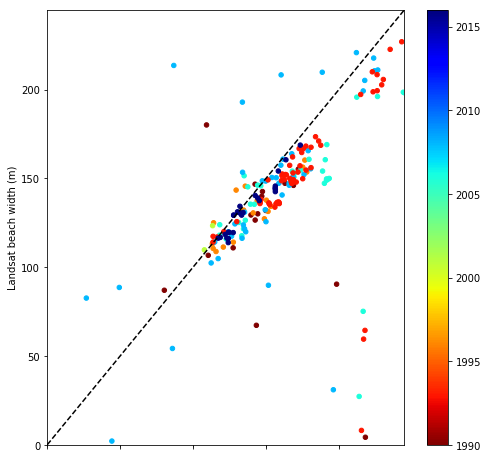

In [324]:
# Import waterline contours
contours_gdf = gpd.read_file('output_data/avoca_utm/avoca_utm_ndwi_combined.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  
contours_gdf['date'] = contours_gdf['date'].astype(int)

# Summarise by year and subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist.groupby(['site', shoreline_dist.date.dt.year]).median()[['ahd0.0_dist', 'origin_x', 'origin_y', 'end_x', 'end_y']].dropna()
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='date')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test.head()

# Plot
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=merge_test.date, cmap='jet_r', figsize=(8, 8))
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);


## Gold Coast

In [319]:
import itertools
sites = ['KIRRA', 'BILINGA', 'COOLANGATTA', 'TUGUN', 'NORTH KIRRA', 'RAINBOW BAY', 'SNAPPER ROCKS']
sites = ['NORTH KIRRA', 'RAINBOW BAY', 'SNAPPER ROCKS']
profile_list = list(itertools.chain.from_iterable(glob.glob(f'validation/ETA Lines- 20181213/{i}*.txt') for i in sites))

output_list = []
failed_list = []

for profile_i in profile_list:
    
    try:

        # Identify unique field values from file string
        profile_string = os.path.basename(profile_i)

        if len(profile_string.split(' - ')) > 3:
    
            beach, section, profile, id_date = profile_string.split(' - ')
            name = (beach + '_' + section + profile).replace('\xa0', '').replace(' ', '_')
            
        else:
            
            beach, profile, id_date = profile_string.split(' - ')
            name = (beach + '_' + profile).replace('\xa0', '').replace(' ', '_')
    
        date = id_date[-14:-4]

        # Import data and add in fields
        profile_df = pd.read_csv(profile_i, delim_whitespace=True, names=['point_id', 'x', 'y', 'z'])
        profile_df['date'] = date
        profile_df['site'] = name

        output_list.append(profile_df)
        
    except:
        
        failed_list.append(profile_i)


In [320]:
# Combine into a single dataframe, and drop pre-1987 and deep water samples
profiles_df = pd.concat(output_list)
profiles_df = profiles_df[profiles_df.z > -3.0]
profiles_df = profiles_df[profiles_df.date > '1987']
profiles_df.drop('point_id', axis=1, inplace=True)
profiles_df.head()

# Compute origin and end points for each profile
origin_xy = profiles_df.groupby(['site']).first().reset_index()[['site', 'x', 'y']]
end_xy = profiles_df.groupby(['site']).last().reset_index()[['site', 'x', 'y']]
origin_xy.rename({'x': 'origin_x', 'y': 'origin_y'}, inplace=True, axis=1)
end_xy.rename({'x': 'end_x', 'y': 'end_y'}, inplace=True, axis=1)
end_xy.reset_index(drop=True, inplace=True)
origin_xy.reset_index(drop=True, inplace=True)

# Join origin and end points into dataframe
profiles_df = pd.merge(left=profiles_df, right=origin_xy)
profiles_df = pd.merge(left=profiles_df, right=end_xy)

profiles_df['Chainage'] = profiles_df.apply(lambda x: math.hypot(x.x - x.origin_x, x.y - x.origin_y), axis = 1)

# Find location and distance to water / X AHD
profiles_interp = []

for i in [0.0, 0.5, 1.0]:

    out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp1d(x.z, x.Chainage)(i),
                                                                           f'ahd{i}_x': interp1d(x.z, x.x)(i),
                                                                           f'ahd{i}_y': interp1d(x.z, x.y)(i)})
                                                      
                                                      if (x.z.min() < i) & (x.z.max() > i) 
                                                      
                                                      else pd.Series({f'ahd{i}_dist': np.nan,
                                                                      f'ahd{i}_x': np.nan,
                                                                      f'ahd{i}_y': np.nan}))
    
    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['Chainage', 'z', 'x', 'y'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Fix datetime
shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

# Insert annotation column
shoreline_dist.insert(2, 'source', 'GCC_hydrographic')
shoreline_dist.tail()

# Restrict to mid year months
# shoreline_dist = shoreline_dist[(shoreline_dist.date.dt.month > 4) & (shoreline_dist.date.dt.month < 9)]

,site,date,source,origin_x,origin_y,end_x,end_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
756,SNAPPER_ROCKS_SR_2,2013-08-14,GCC_hydrographic,554031.1957,6.884570e+06,554082.6214,6.884625e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,SNAPPER_ROCKS_SR_2,2014-07-31,GCC_hydrographic,554031.1957,6.884570e+06,554082.6214,6.884625e+06,57.66564,554070.251214,6.884612e+06,NaN,NaN,NaN,NaN,NaN,NaN
758,SNAPPER_ROCKS_SR_2,2015-11-05,GCC_hydrographic,554031.1957,6.884570e+06,554082.6214,6.884625e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
759,SNAPPER_ROCKS_SR_2,2017-07-27,GCC_hydrographic,554031.1957,6.884570e+06,554082.6214,6.884625e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
760,SNAPPER_ROCKS_SR_2,2018-10-24,GCC_hydrographic,554031.1957,6.884570e+06,554082.6214,6.884625e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


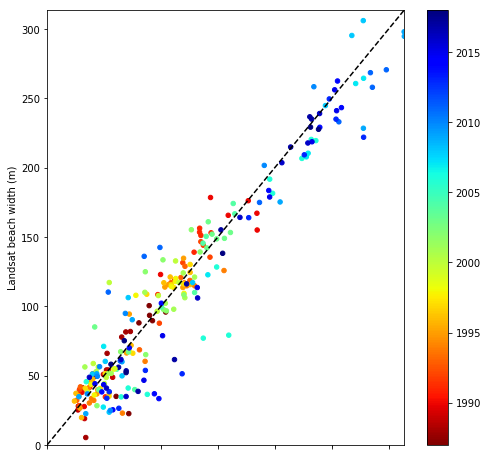

In [321]:
# Import waterline contours
contours_gdf = gpd.read_file('output_data/goldcoast1/goldcoast1_ndwi_combined.shp')
contours_gdf = contours_gdf.to_crs(epsg=28356)  
contours_gdf['date'] = contours_gdf['date'].astype(int)

# Summarise by year and subset to AHD 0.0 data
shoreline_ahd0 = shoreline_dist.groupby(['site', shoreline_dist.date.dt.year]).median()[['ahd0.0_dist', 'origin_x', 'origin_y', 'end_x', 'end_y']].dropna()
shoreline_ahd0_geometry  = shoreline_ahd0.apply(lambda x: LineString([Point(x.origin_x, x.origin_y), Point(x.end_x, x.end_y)]), axis = 1)
shoreline_ahd0_gdf = gpd.GeoDataFrame(shoreline_ahd0, geometry=shoreline_ahd0_geometry).reset_index()
shoreline_ahd0_gdf.crs = 'EPSG:28356'

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_ahd0_gdf.merge(contours_gdf, on='date')

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_x.intersection(x.geometry_y).distance(Point(x.origin_x, x.origin_y)), axis=1)
merge_test = merge_test.rename({'ahd0.0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test.head()

# Plot
dist_lim = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].max(axis=0).max()
merge_test[['Validation beach width (m)', 'Landsat beach width (m)']].plot.scatter(x='Validation beach width (m)', 
                                                                                   y='Landsat beach width (m)', 
                                                                                   c=merge_test.date, cmap='jet_r', figsize=(8, 8))
plt.plot(np.linspace(0, dist_lim), np.linspace(0, dist_lim), 'black', linestyle='dashed')
plt.ylim([0, dist_lim]); plt.xlim([0, dist_lim]);


In [322]:
((merge_test['Landsat beach width (m)'] - merge_test['Validation beach width (m)'] - 10) ** 2).mean() ** .5

23.885667621047123

['/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 1 - (10750) 1984-05-17.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - BETA 3.3 - (24646) 2011-08-01.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - PSM 18 - (10692) 1995-05-30.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 7 - (11136) 1997-09-17.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 8 - (11178) 1990-05-08.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 2 - (10845) 1991-11-05.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 6a - (14204) 1987-09-16.txt',
 '/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/ETA Lines- 20181213/KIRRA - K 1 - (23856) 